In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 22
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.04, identitity_weight_decay=0.9)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/12 | batch 2001/2000 | loss 1.1801 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5157 | pr auc 0.2466 | elapsed 36.97s
train epoch 01/12 | batch 2001/2000 | loss 0.8691 | val loss 0.4809 | acc 0.8211 | f1 0.3913 | prec 0.7121 | recall 0.2698 | roc auc 0.6834 | pr auc 0.5078 | elapsed 91.15s
train epoch 02/12 | batch 2001/2000 | loss 0.5732 | val loss 0.3681 | acc 0.8580 | f1 0.5749 | prec 0.7942 | recall 0.4504 | roc auc 0.8267 | pr auc 0.6944 | elapsed 89.60s
train epoch 03/12 | batch 2001/2000 | loss 0.4358 | val loss 0.2986 | acc 0.8920 | f1 0.7039 | prec 0.8467 | recall 0.6023 | roc auc 0.8825 | pr auc 0.7979 | elapsed 97.97s
train epoch 04/12 | batch 2001/2000 | loss 0.3457 | val loss 0.2551 | acc 0.9121 | f1 0.7661 | prec 0.8851 | recall 0.6754 | roc auc 0.9085 | pr auc 0.8471 | elapsed 96.75s
train epoch 05/12 | batch 2001/2000 | loss 0.2846 |

In [ ]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20240710T211205/reasoner.pt'))


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col])
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col])

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [5]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/22 | batch 751/750 | loss 1.1772 | val loss 1.0682 | acc 0.6514 | f1 0.4037 | prec 0.3214 | recall 0.5425 | roc auc 0.6499 | pr auc 0.4861 | elapsed 14.05s
train epoch 01/22 | batch 751/750 | loss 1.0543 | val loss 0.8406 | acc 0.7060 | f1 0.4494 | prec 0.3791 | recall 0.5517 | roc auc 0.6984 | pr auc 0.5318 | elapsed 28.95s
train epoch 02/22 | batch 751/750 | loss 0.8118 | val loss 0.6642 | acc 0.7554 | f1 0.5064 | prec 0.4512 | recall 0.5770 | roc auc 0.7490 | pr auc 0.5864 | elapsed 26.74s
train epoch 03/22 | batch 751/750 | loss 0.6307 | val loss 0.5347 | acc 0.7970 | f1 0.5611 | prec 0.5296 | recall 0.5966 | roc auc 0.7963 | pr auc 0.6455 | elapsed 26.93s
train epoch 04/22 | batch 751/750 | loss 0.4973 | val loss 0.4406 | acc 0.8291 | f1 0.6135 | prec 0.6038 | recall 0.6236 | roc auc 0.8368 | pr auc 0.7043 | elapsed 26.84s
train epoch 05/22 | batch 751/750 | loss 0.4018 | val loss 0.3726 | acc 0.8558 | f1 0.6649 | prec 0.6719 | recall 0.6580 | roc a

In [6]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240710T211205


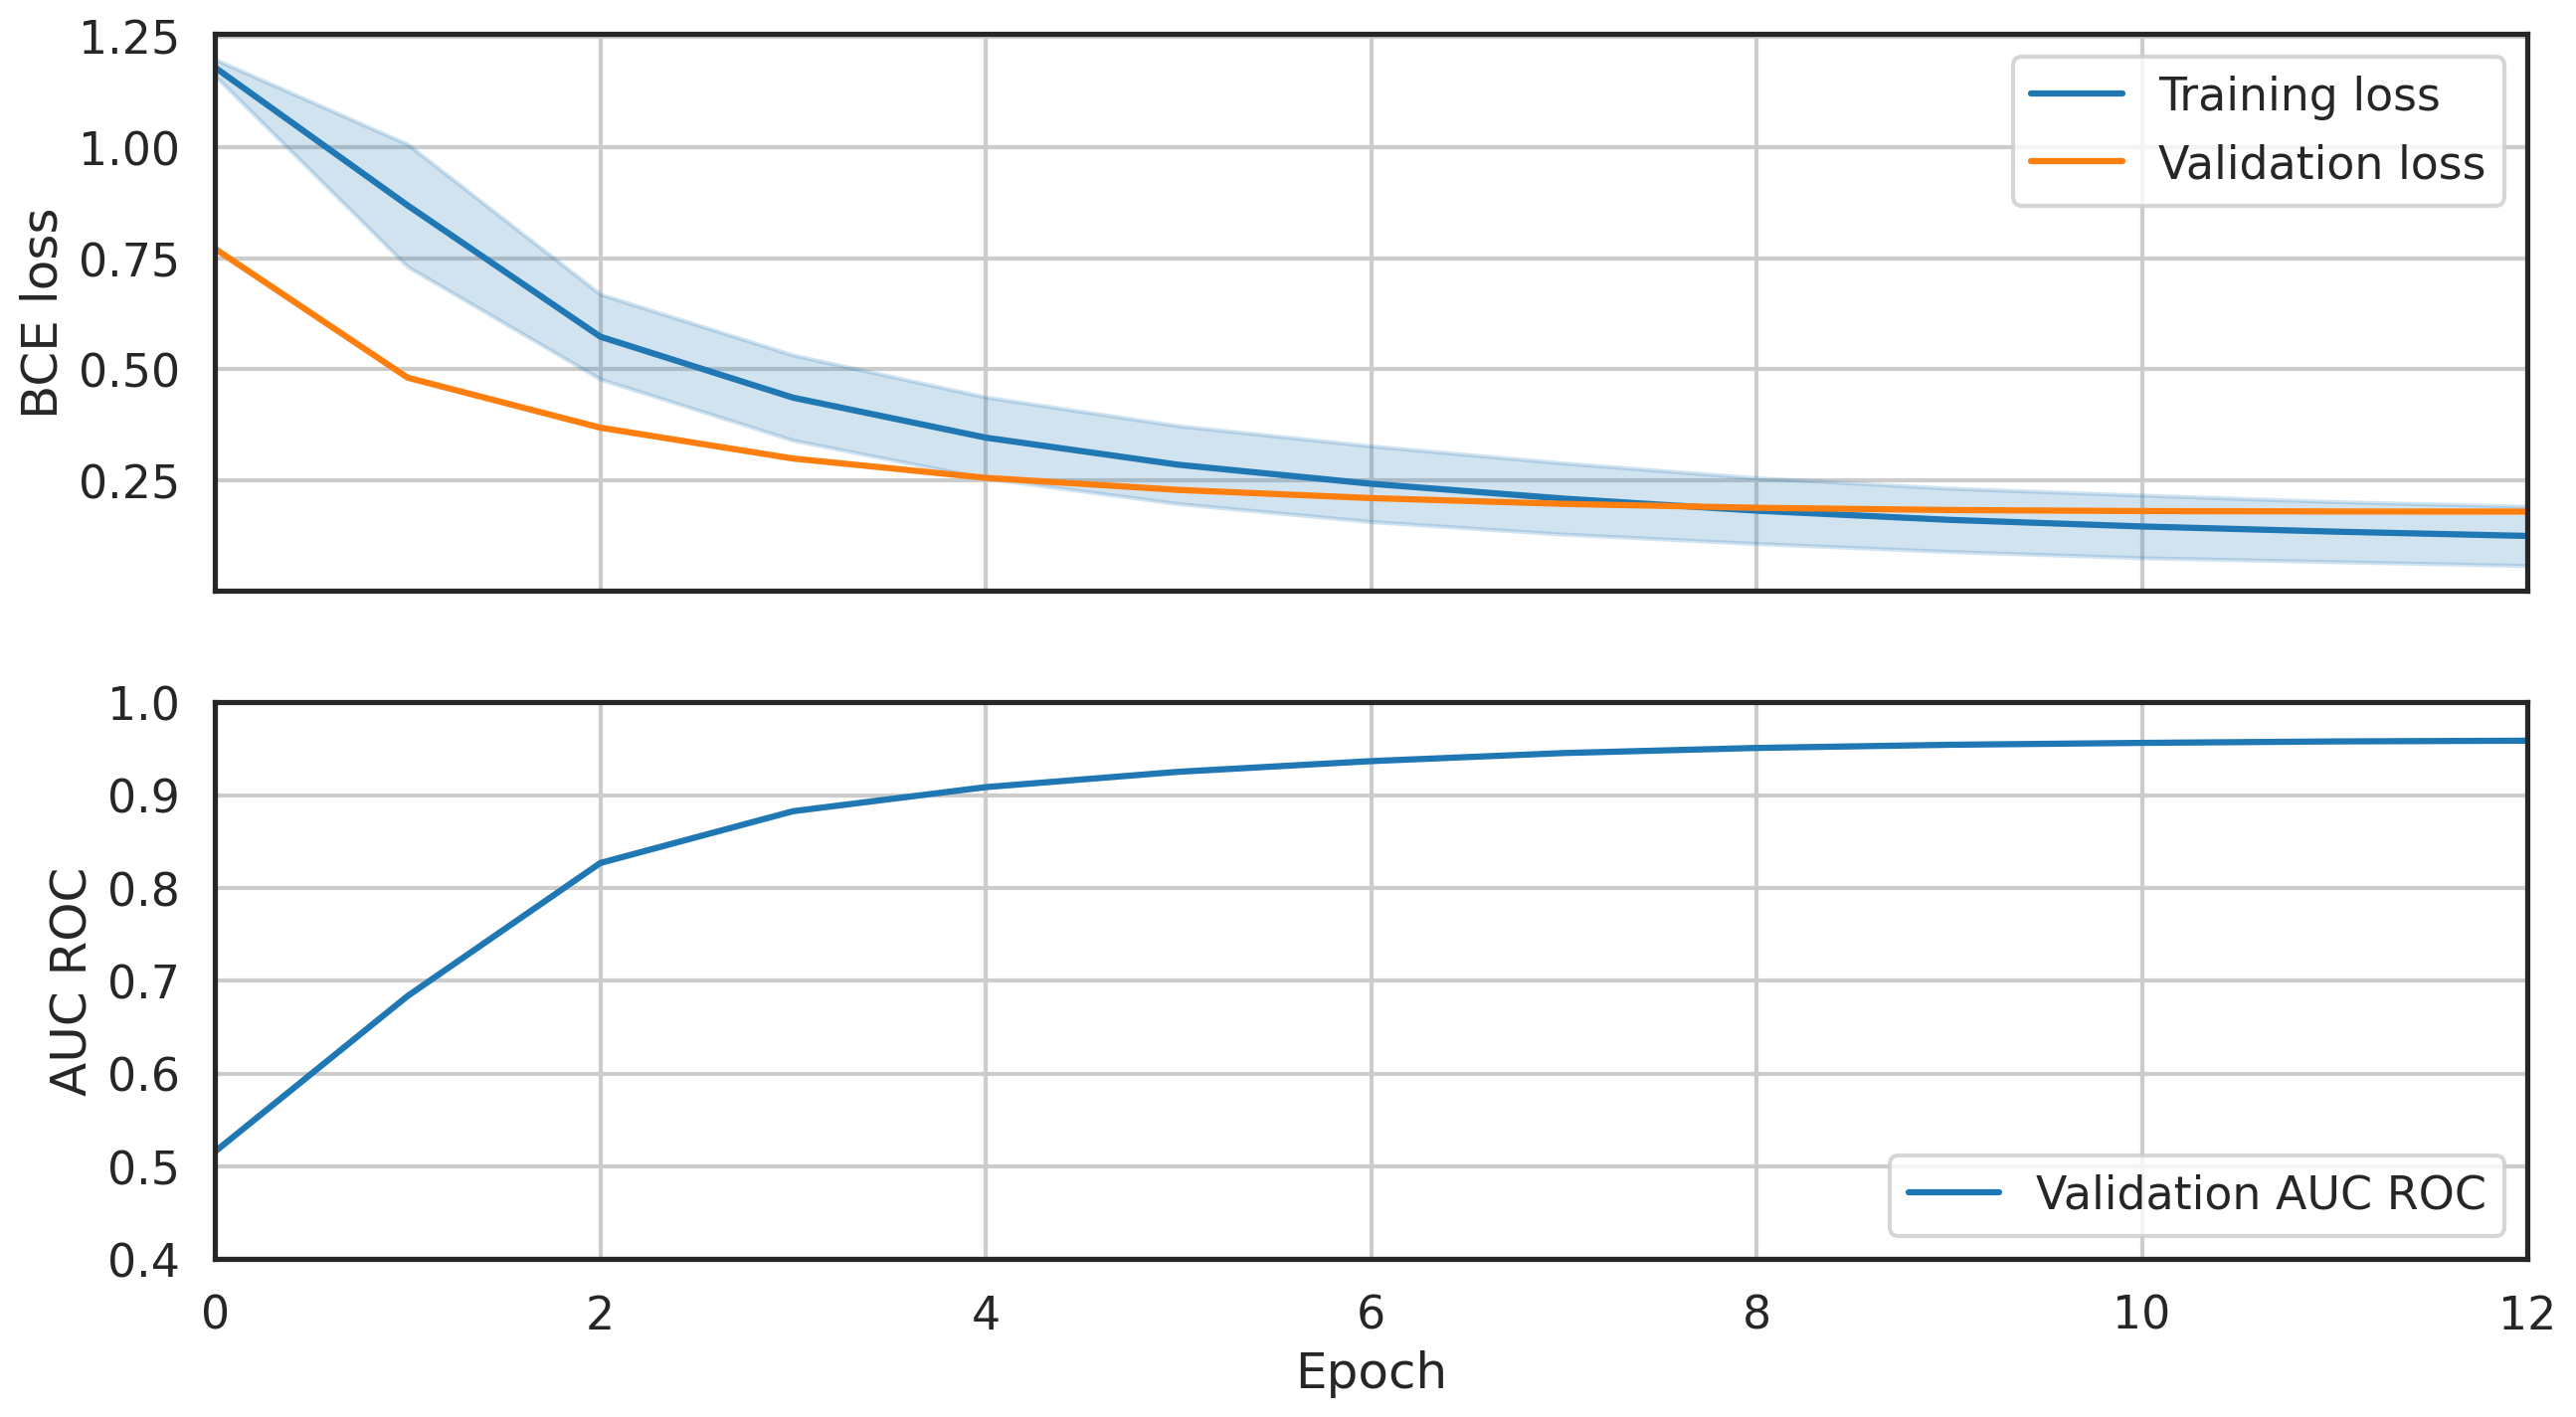

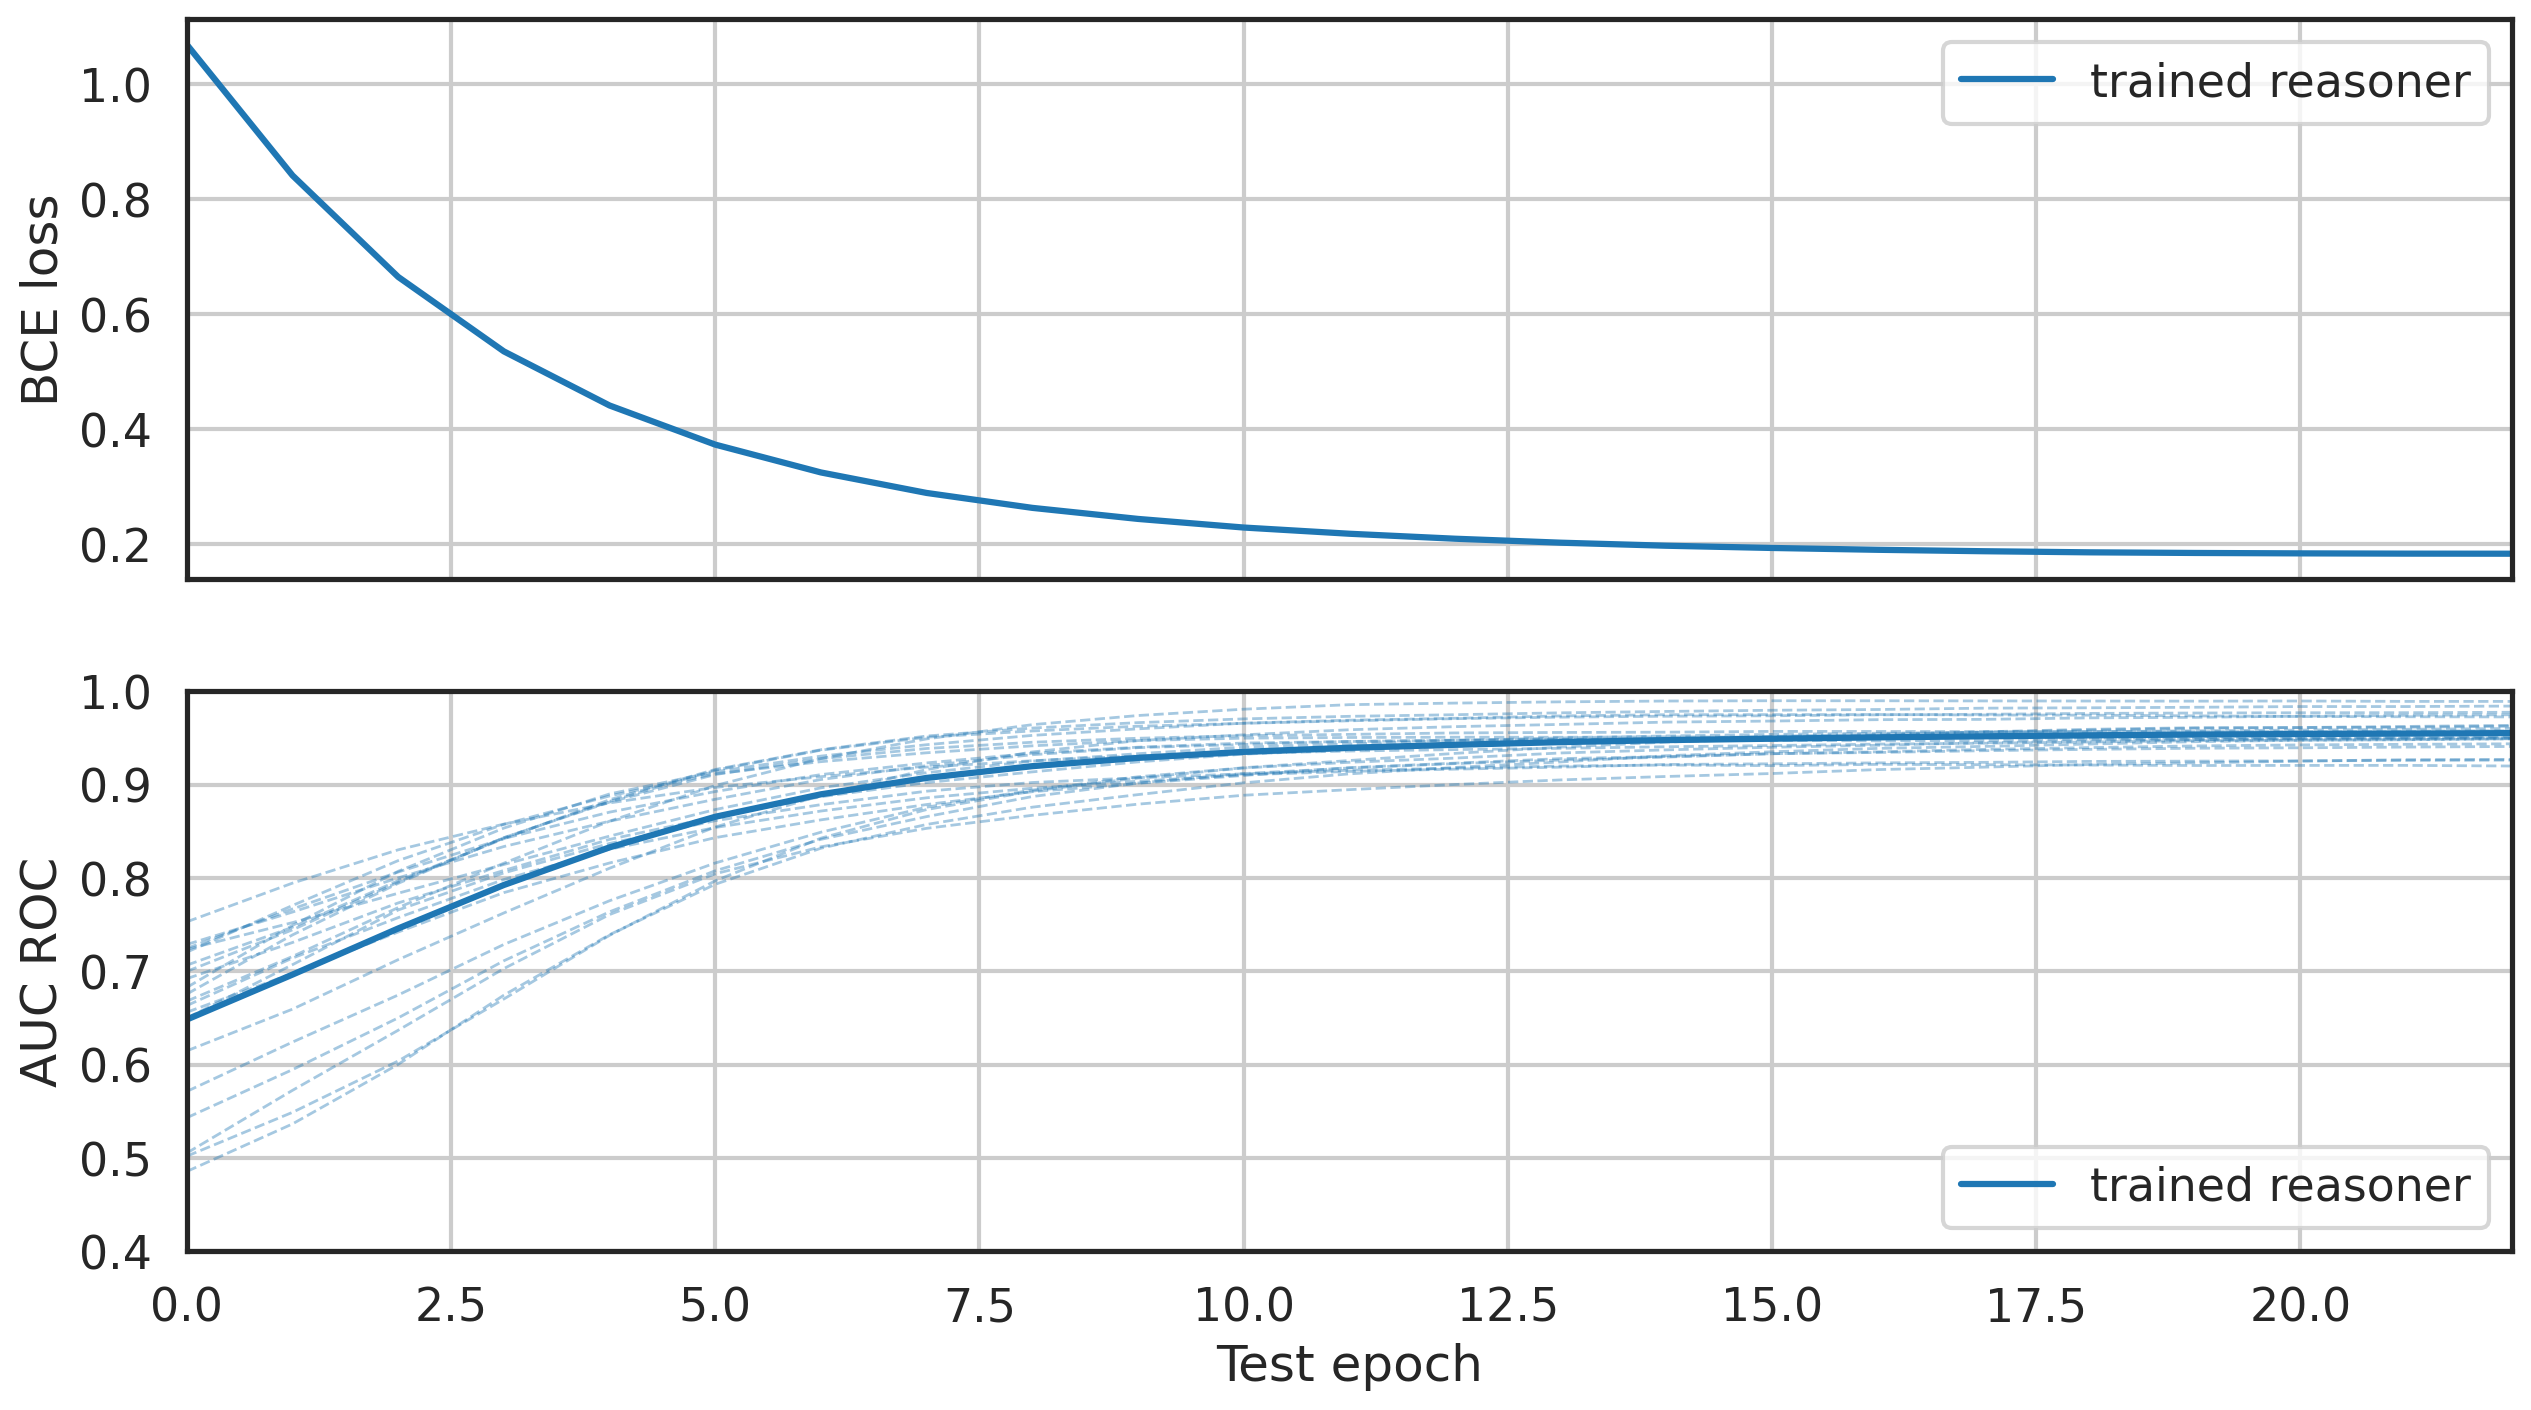

             mean       std     micro
acc      0.936125  0.023543  0.936125
prec     0.888121  0.053206  0.889594
recall   0.802577  0.080198  0.806210
f1       0.842038  0.063755  0.845852
auc_roc  0.945124  0.025889  0.948328
auc_pr   0.907717  0.046190  0.914709


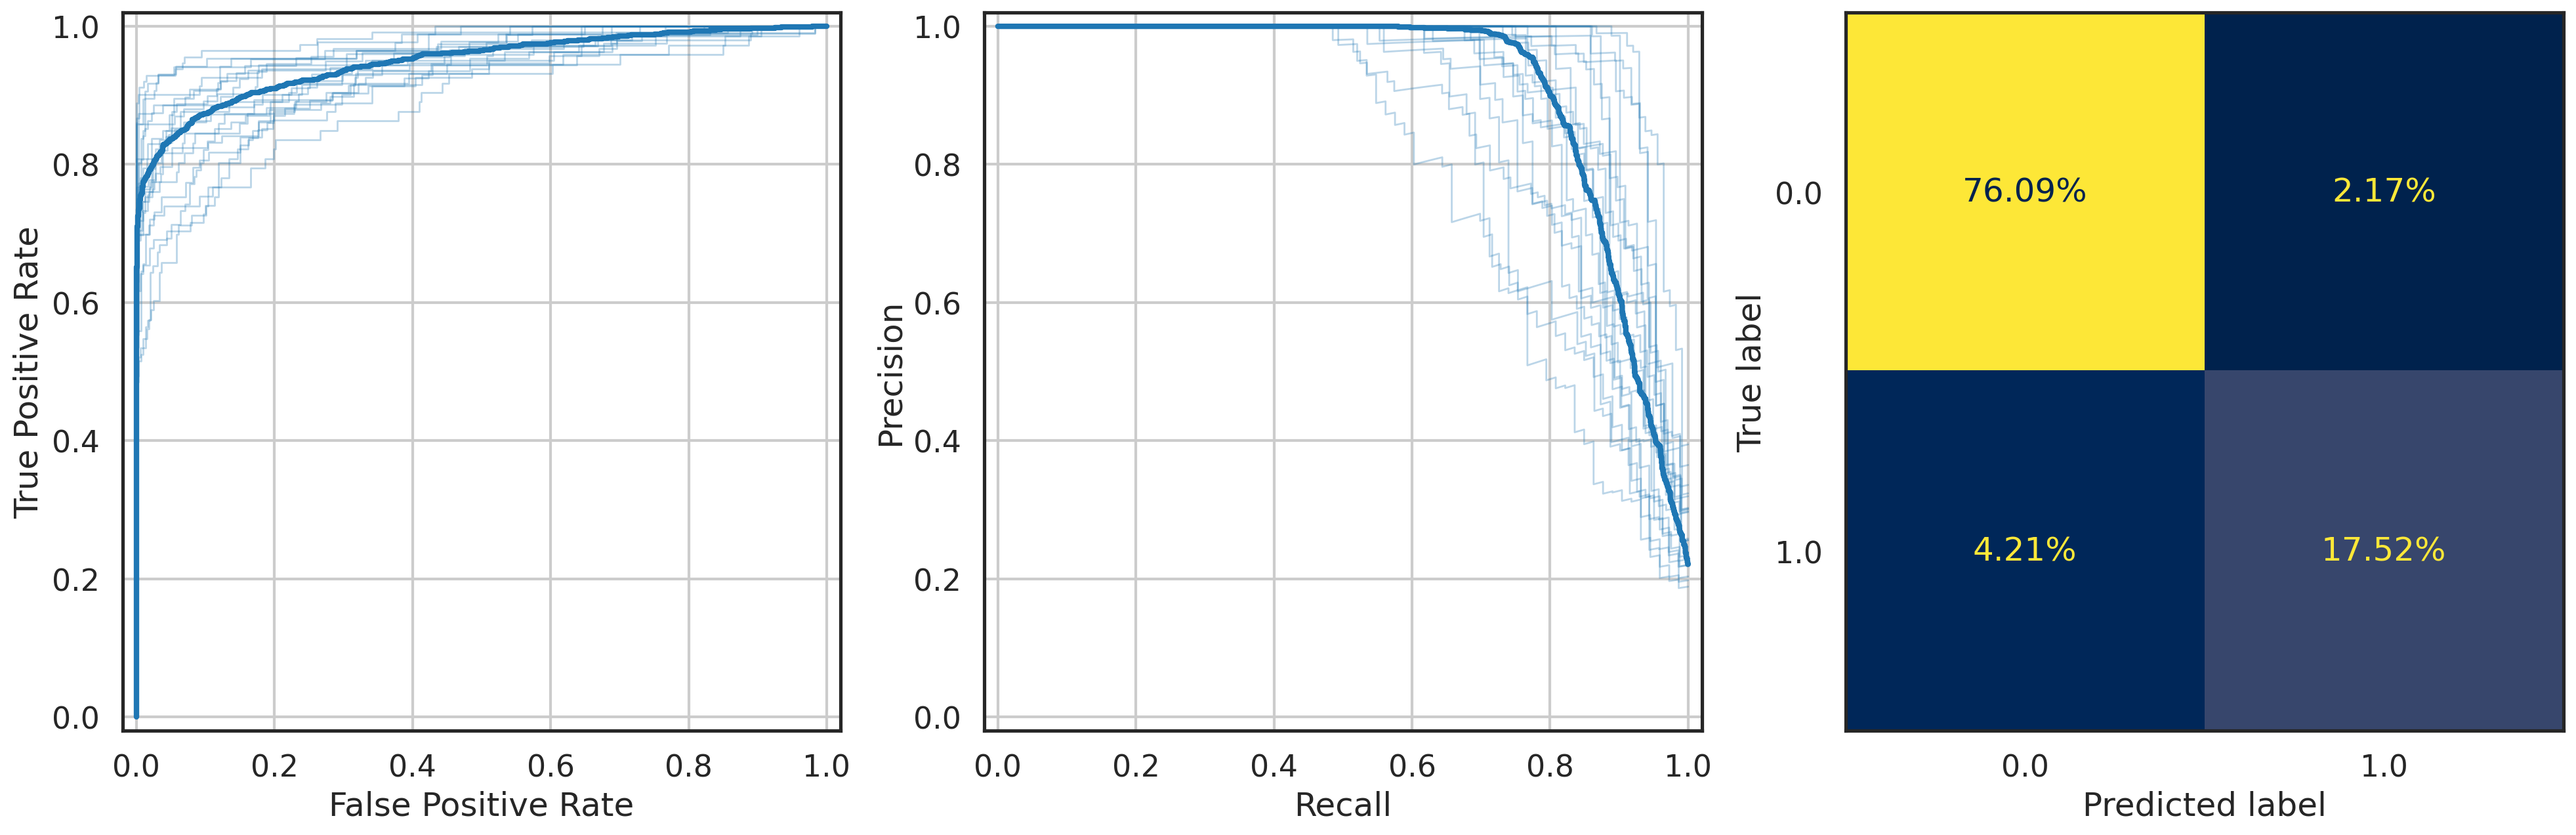

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [8]:
T.set_printoptions(precision=4)

In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([-0.1849, -0.1518,  0.2189, -0.0524,  0.0848, -0.0213, -0.0965, -0.1704,
         0.1463,  0.1277], grad_fn=<SelectBackward0>)
tensor([-0.0179, -0.1213,  0.0300, -0.0498,  0.0513, -0.1595, -0.1322, -0.1521,
         0.0507,  0.0863], grad_fn=<AddBackward0>)
0.10363315083086491


In [10]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.3702,  0.1625,  0.1191, -0.2891,  0.3651, -0.0304,  0.0779,  0.1033,
        -0.2300, -0.1701], grad_fn=<AddBackward0>)
0.021138253435492516


In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.2533, -0.0876, -0.1021,  0.3701, -0.2346,  0.0287,  0.4094, -0.0547,
         0.2255,  0.1455], grad_fn=<SelectBackward0>)
tensor([-0.2002, -0.2046, -0.0685,  0.2897, -0.2133,  0.0597,  0.1458, -0.0518,
         0.1343,  0.1532], grad_fn=<AddBackward0>)
0.08721585981547833


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.2296,  0.1609,  0.0715, -0.2188,  0.2927,  0.0339,  0.1166,  0.0970,
        -0.1757, -0.0788], grad_fn=<AddBackward0>)
0.18313054349273444


In [13]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.3252,  0.2089,  0.1086, -0.2964,  0.3826, -0.0210,  0.1023,  0.1166,
        -0.2647, -0.1439], grad_fn=<SqueezeBackward3>)
tensor(0.0005, grad_fn=<L1LossBackward0>)


In [14]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0740, -0.2704, -0.0439,  0.3957,  0.0404,  0.2183,  0.7550,  0.0279,
        -0.1043,  0.3512], grad_fn=<SelectBackward0>)
tensor([-0.0739, -0.2698, -0.0433,  0.3955,  0.0405,  0.2182,  0.7542,  0.0282,
        -0.1044,  0.3505], grad_fn=<SqueezeBackward3>)
tensor(0.0004, grad_fn=<L1LossBackward0>)


In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.0258, -0.1215,  0.0393, -0.1228,  0.0491, -0.1432, -0.0981, -0.1297,
         0.0472,  0.0766], grad_fn=<AddBackward0>)
tensor([ 0.0365, -0.1286,  0.0379, -0.0929,  0.0574, -0.1691, -0.1252, -0.1321,
         0.0526,  0.0809], grad_fn=<AddBackward0>)
0.02178059467114508


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([-0.0048, -0.1762,  0.0345, -0.0594, -0.0022, -0.1855, -0.1645, -0.1700,
         0.0846,  0.1504], grad_fn=<AddBackward0>)
tensor([-0.0235, -0.1722, -0.0327, -0.0667,  0.0080, -0.1848, -0.1604, -0.1544,
         0.0704,  0.1136], grad_fn=<AddBackward0>)
0.023547200160101055


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.2543,  0.1255,  0.2573, -0.5110,  0.1136,  0.1557,  0.0968,  0.0510,
        -0.2252, -0.1366], grad_fn=<SelectBackward0>)
tensor([ 0.2472,  0.1972,  0.1897, -0.3243,  0.2492,  0.0798,  0.0893,  0.1056,
        -0.2332, -0.1796], grad_fn=<AddBackward0>)
0.07480547465384006


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9990518718957901


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999817609786987


In [20]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999817609786987
